In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from IsingSolutions import ising2d as ising2d_exact
from scipy.interpolate import interp1d,PchipInterpolator
from glob import glob
import numpy as np


In [25]:

# get all csv dataframes in the glob
filenames=glob('./data/ising2d_gilt_X16_scan_params_observables/*.csv')

dfs=[]
for filename in filenames:
    df=pd.read_csv(filename)
    dfs.append(df)
df=pd.concat(dfs)

In [27]:
df['magnetization_binder']=df['magnetization_4']/df['magnetization_2']**2

exact_critical_beta=ising2d_exact.critical_beta
nLayers=df['iLayer'].max()+1
iLayers=np.arange(0,nLayers,2)
beta_min,beta_max=df['beta'].min(),df['beta'].max()
betas=np.linspace(beta_min,beta_max,1000)
cm=plt.get_cmap('jet')

plt.rcParams.update({'font.size': 14,'legend.fontsize':10})

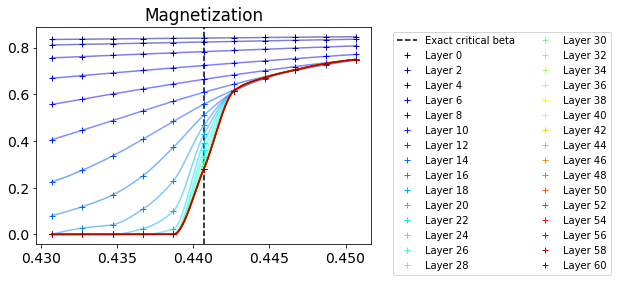

In [29]:
plt.figure(figsize=(6,4))
plt.title('Magnetization')
plt.axvline(exact_critical_beta,color='k',linestyle='--',label='Exact critical beta')
for iLayer in iLayers:
    df1=df[df['iLayer']==iLayer].sort_values('beta')
    plt.plot(df1['beta'],df1['magnetization'],'+',label='Layer %d'%iLayer,color=cm(iLayer/nLayers))
    f1=PchipInterpolator(df1['beta'],df1['magnetization'])
    plt.plot(betas,f1(betas),color=cm(iLayer/nLayers,alpha=.5))
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

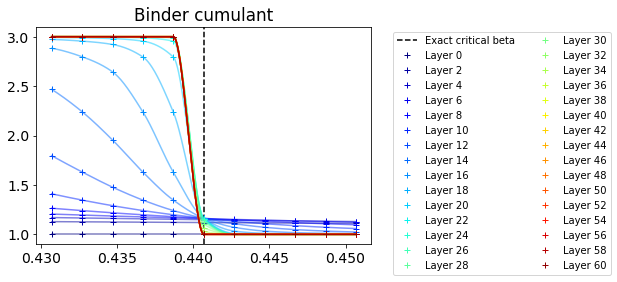

In [30]:


plt.figure(figsize=(6,4))
plt.title('Binder cumulant')
plt.axvline(exact_critical_beta,color='k',linestyle='--',label='Exact critical beta')
for iLayer in iLayers:
    df1=df[df['iLayer']==iLayer].sort_values('beta')
    plt.plot(df1['beta'],df1['magnetization_binder'],'+',label='Layer %d'%iLayer,color=cm(iLayer/nLayers))
    # f1=interp1d(df1['beta'],df1['magnetization_binder'],kind='linear')
    f1=PchipInterpolator(df1['beta'],df1['magnetization_binder'])
    plt.plot(betas,f1(betas),color=cm(iLayer/nLayers,alpha=.5))
# plt.ylim(1.1,1.2)
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

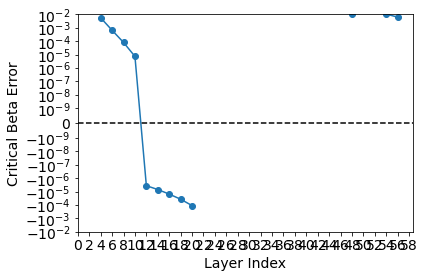

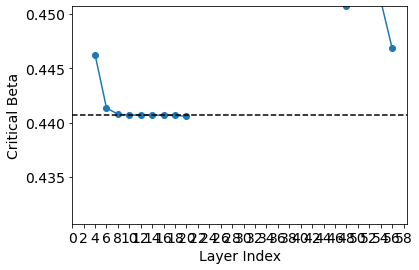

In [41]:
# for layer i and i+1, find the crossing point of the binder
# plot i vs crossing point
# find the crossing point by spline fitting

from scipy.optimize import minimize,root
from scipy.interpolate import interp1d
from matplotlib.scale import SymmetricalLogScale

crossings=[]
beta_min,beta_max=df['beta'].min(),df['beta'].max()
betas_interp=np.linspace(beta_min,beta_max,1000)

for iLayer in range(0, nLayers-1, 2):
    df1 = df[df['iLayer'] == iLayer].sort_values('beta')
    df2 = df[df['iLayer'] == iLayer+2].sort_values('beta')

    # f1 = interp1d(df1['beta'], df1['magnetization_binder'], kind='linear')
    # f2 = interp1d(df2['beta'], df2['magnetization_binder'], kind='linear')
    f1 = PchipInterpolator(df1['beta'], df1['magnetization_binder'])
    f2 = PchipInterpolator(df2['beta'], df2['magnetization_binder'])
    
    # crossing=minimize(lambda x: (f1(x)-f2(x))**2, (beta_min+beta_max)/2, bounds=[(beta_min,beta_max)]).x[0]
    # if np.abs(f1(crossing)-f2(crossing))>.1:
    #     crossing=np.nan
    result=root(lambda x: f1(x)-f2(x), (beta_min+beta_max)/2)
    crossing=result.x[0] if result.success else np.nan

    # Append the crossing point to the list of crossings
    crossings.append(crossing)

plt.plot(range(0, nLayers-1, 2), (crossings-exact_critical_beta), 'o-')
plt.axhline(0, color='k', linestyle='--')
plt.yscale(SymmetricalLogScale(axis='y',base=10, linthresh=1e-9))
plt.ylim(beta_min-exact_critical_beta,beta_max-exact_critical_beta)
plt.xticks(range(0, nLayers-1, 2))
plt.xlabel('Layer Index')
plt.ylabel('Critical Beta Error')
plt.show()

plt.plot(range(0, nLayers-1, 2), crossings, 'o-')
plt.axhline(exact_critical_beta, color='k', linestyle='--')
plt.ylim(beta_min,beta_max)
plt.xticks(range(0, nLayers-1, 2))
plt.xlabel('Layer Index')
plt.ylabel('Critical Beta')
plt.show()